## **Importing libraries and datasets**

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from google.colab import drive

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import data**

In [ ]:
df_response = pd.read_csv('drive/MyDrive/CRM/Retail_Data_Response.csv')
df_transactions = pd.read_csv('drive/MyDrive/CRM/Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [ ]:
df_response.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [ ]:
df_transactions.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


## **Data Preparation**

In [ ]:
# data 2 years ago
date_before = dt.date(2013,3,16)
date_end = dt.date(2015,3,16)

df_transactions = df_transactions[(df_transactions['trans_date'].dt.date > date_before) & (df_transactions['trans_date'].dt.date <= date_end)]
df_transactions

,customer_id,trans_date,tran_amount
1,CS4768,2015-03-15,39
4,CS1850,2013-11-20,78
5,CS5539,2014-03-26,81
7,CS5902,2015-01-30,89
9,CS3802,2013-08-20,75
...,...,...,...
124991,CS8076,2014-05-16,68
124996,CS7232,2014-08-19,38
124997,CS8731,2014-11-28,42
124998,CS8133,2013-12-14,13


In [ ]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated

campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head()

,customer_id,trans_date,tran_amount,recent
1,CS4768,2015-03-15,39,2.0
4,CS1850,2013-11-20,78,482.0
5,CS5539,2014-03-26,81,356.0
7,CS5902,2015-01-30,89,46.0
9,CS3802,2013-08-20,75,574.0


In [ ]:
## create data set with CLV variables

df_clv = df_transactions.groupby('customer_id').agg({'recent': lambda x:x.min(),                      # Recency
                                                     'customer_id': lambda x: len(x),                 # Frequency
                                                     'tran_amount': lambda x: x.sum(),                # Monetary Value           
                                                     'trans_date': lambda x: (x.max() - x.min()).days})       # AOU

df_clv.rename(columns={'recent': 'recency', 
                       'customer_id': 'frequency', 
                       'tran_amount': 'monetary_value',
                       'trans_date' : 'AOU'}, inplace=True)

df_clv['ticket_size'] = df_clv['monetary_value'] / df_clv['frequency']

In [ ]:
df_clv = df_clv.reset_index()
df_clv.head()

,customer_id,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,62.0,6,358,562,59.666667
1,CS1113,36.0,11,775,660,70.454545
2,CS1114,33.0,11,804,626,73.090909
3,CS1115,12.0,11,831,715,75.545455
4,CS1116,204.0,5,333,199,66.600000


## **Calculating response rate**

In [ ]:
response_rate = df_response.groupby('response').agg({'customer_id': lambda x: len(x)}).reset_index()
response_rate.head()

,response,customer_id
0,0,6237
1,1,647


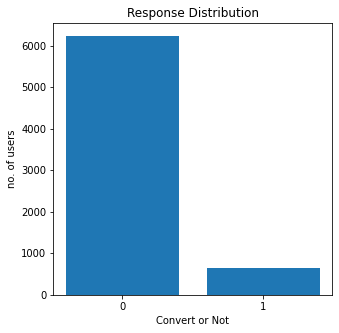

In [ ]:
plt.figure(figsize=(5,5))
x=range(2)
plt.bar(x,response_rate['customer_id'])
plt.xticks(response_rate.index)
plt.title('Response Distribution')
plt.xlabel('Convert or Not')
plt.ylabel('no. of users')
plt.show()

## data is imbalanced

In [ ]:
## merging two data sets - CLV

df_modeling_clv = pd.merge(df_response,df_clv)
df_modeling_clv.head()

,customer_id,response,recency,frequency,monetary_value,AOU,ticket_size
0,CS1112,0,62.0,6,358,562,59.666667
1,CS1113,0,36.0,11,775,660,70.454545
2,CS1114,1,33.0,11,804,626,73.090909
3,CS1115,1,12.0,11,831,715,75.545455
4,CS1116,1,204.0,5,333,199,66.600000


## **Creating train and test dataset**

In [ ]:
## spliting dataframe into X and y

X_clv = df_modeling_clv.drop(columns=['response','customer_id'])
y_clv = df_modeling_clv['response']

In [ ]:
## creating train and test dataset

X_train_clv, X_test_clv, y_train_clv, y_test_clv = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

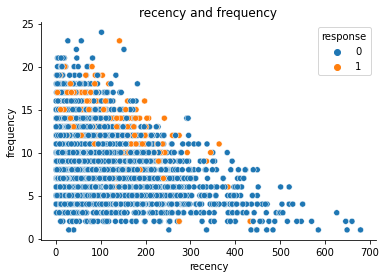

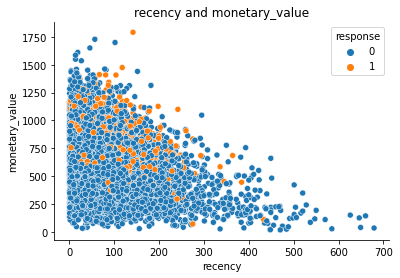

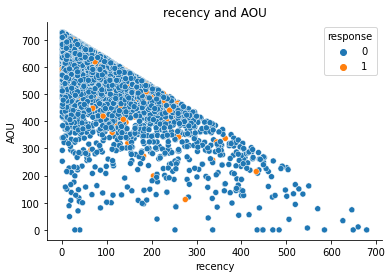

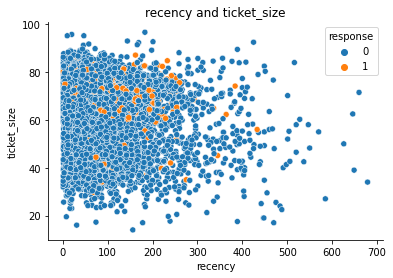

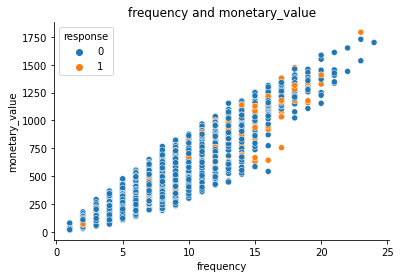

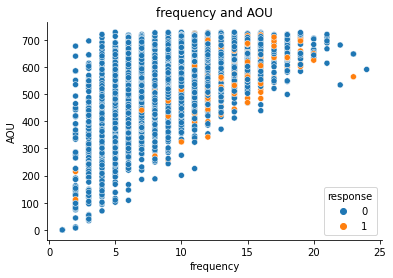

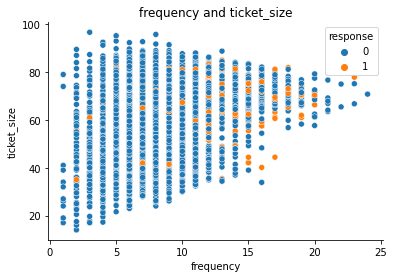

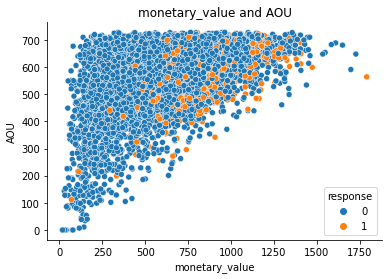

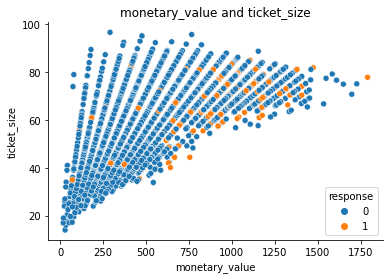

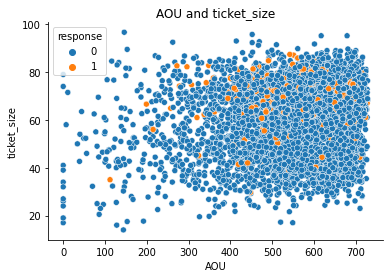

In [ ]:
for i, col_i in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling_clv[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling_clv, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

## **K Means**

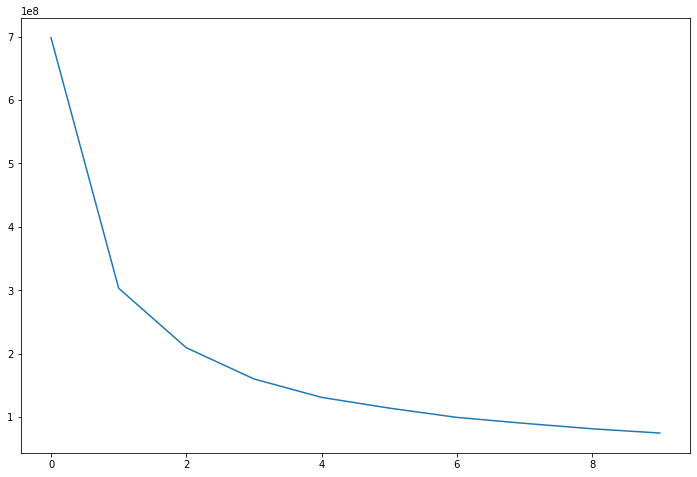

In [ ]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
  kmeans.fit(X_clv.values)
  inertia.append(kmeans.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(inertia)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(X_clv.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [ ]:
X_clv['cluster'] = kmeans.labels_
X_clv

,recency,frequency,monetary_value,AOU,ticket_size,cluster
0,62.0,6,358,562,59.666667,0
1,36.0,11,775,660,70.454545,2
2,33.0,11,804,626,73.090909,1
3,12.0,11,831,715,75.545455,1
4,204.0,5,333,199,66.600000,0
...,...,...,...,...,...,...
6879,98.0,7,369,377,52.714286,0
6880,262.0,6,246,392,41.000000,0
6881,85.0,5,205,591,41.000000,0
6882,258.0,4,107,363,26.750000,0


In [ ]:
dummy_cluster = pd.get_dummies(X_clv['cluster'], prefix='cluster')
X_clv = pd.merge(
    left=X_clv,
    right=dummy_cluster,
    left_index=True,
    right_index=True,
)
X_clv

,recency,frequency,monetary_value,AOU,ticket_size,cluster,cluster_0,cluster_1,cluster_2
0,62.0,6,358,562,59.666667,0,1,0,0
1,36.0,11,775,660,70.454545,2,0,0,1
2,33.0,11,804,626,73.090909,1,0,1,0
3,12.0,11,831,715,75.545455,1,0,1,0
4,204.0,5,333,199,66.600000,0,1,0,0
...,...,...,...,...,...,...,...,...,...
6879,98.0,7,369,377,52.714286,0,1,0,0
6880,262.0,6,246,392,41.000000,0,1,0,0
6881,85.0,5,205,591,41.000000,0,1,0,0
6882,258.0,4,107,363,26.750000,0,1,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


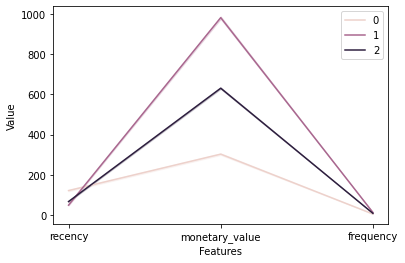

In [ ]:
melted_RFM=pd.melt(X_clv.reset_index(),
                  id_vars=['cluster'],
                   value_vars=['recency','monetary_value','frequency'],
                   var_name='Features',
                   value_name='Value'
                  )

sns.lineplot('Features','Value',hue='cluster',data=melted_RFM)
plt.legend()

## **Split train test**

In [ ]:
X_clv = X_clv.drop(columns=['cluster'])
X_clv

,recency,frequency,monetary_value,AOU,ticket_size,cluster_0,cluster_1,cluster_2
0,62.0,6,358,562,59.666667,1,0,0
1,36.0,11,775,660,70.454545,0,0,1
2,33.0,11,804,626,73.090909,0,1,0
3,12.0,11,831,715,75.545455,0,1,0
4,204.0,5,333,199,66.600000,1,0,0
...,...,...,...,...,...,...,...,...
6879,98.0,7,369,377,52.714286,1,0,0
6880,262.0,6,246,392,41.000000,1,0,0
6881,85.0,5,205,591,41.000000,1,0,0
6882,258.0,4,107,363,26.750000,1,0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clv, y_clv, test_size=0.3, random_state=0)

print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (4818, 8)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 8)
Number transactions y_test dataset:  (2066,)


Text(0.5, 1.0, 'Imbalanced Data')

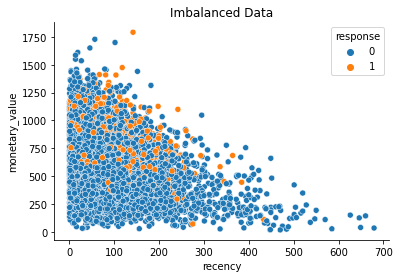

In [ ]:
sns.scatterplot(data=df_modeling_clv, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Imbalanced Data")

## **Fixing imbalanced with Undersampling**

In [ ]:
rus = RandomUnderSampler(random_state=0)
rus.fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Fixing imbalanced with Oversampling**

In [ ]:
ros = RandomOverSampler(random_state=0)
ros.fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Fixing imbalanced with SMOTE**

In [ ]:
sm = SMOTE(random_state=0)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Logistic Regression Model**

In [ ]:
print('logistic regression model - undersampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')

predicted_y = []
expected_y = []

logreg_model_under = logreg.fit(X_undersampled, y_undersampled)
predictions = logreg_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_under.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - undersampled
training set
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       429
           1       0.73      0.76      0.74       429

    accuracy                           0.74       858
   macro avg       0.74      0.74      0.74       858
weighted avg       0.74      0.74      0.74       858

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.77      0.34       218

    accuracy                           0.69      2066
   macro avg       0.59      0.72      0.57      2066
weighted avg       0.88      0.69      0.75      2066



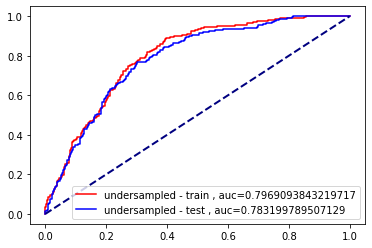

In [ ]:
y_score_train = logreg_model_under.decision_function(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train)
auc_train = roc_auc_score(y_undersampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = logreg_model_under.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
print(logreg_model_under.coef_, logreg_model_under.intercept_)

[[ 8.40770051e-03 -3.80162446e-02  3.14170367e-03  6.88614926e-04
  -1.90137945e-02 -1.73443782e+00  4.75172180e-01 -2.07902653e-01]] [-1.46716829]


In [ ]:
print('logistic regression model - oversampled')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_over = logreg.fit(X_oversampled, y_oversampled)
predictions = logreg_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_over.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - oversampled
training set
              precision    recall  f1-score   support

           0       0.74      0.67      0.71      4389
           1       0.70      0.77      0.73      4389

    accuracy                           0.72      8778
   macro avg       0.72      0.72      0.72      8778
weighted avg       0.72      0.72      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.67      0.79      1848
           1       0.22      0.78      0.34       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.89      0.69      0.75      2066



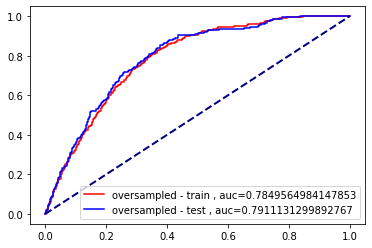

In [ ]:
y_score_train = logreg_model_over.decision_function(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train)
auc_train = roc_auc_score(y_oversampled, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = logreg_model_over.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
print(logreg_model_over.coef_, logreg_model_under.intercept_)

[[ 7.63221190e-03  9.63676526e-02  1.74605288e-03 -4.71032049e-04
  -1.05729241e-02 -1.76079915e+00  2.61313356e-01 -1.78494280e-01]] [-1.46716829]


In [ ]:
print('logistic regression model - SMOTE')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE
training set
              precision    recall  f1-score   support

           0       0.75      0.68      0.71      4389
           1       0.71      0.77      0.74      4389

    accuracy                           0.73      8778
   macro avg       0.73      0.73      0.72      8778
weighted avg       0.73      0.73      0.72      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      1848
           1       0.22      0.77      0.34       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



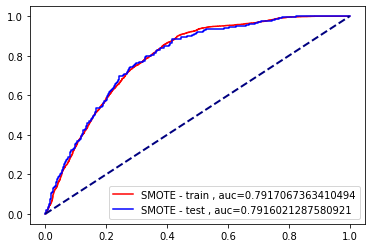

In [ ]:
y_score_train = logreg_model_SMOTE.decision_function(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train)
auc_train = roc_auc_score(y_SMOTE, y_score_train)
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = logreg_model_SMOTE.decision_function(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test)
auc_test = roc_auc_score(y_test, y_score_test)
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

In [ ]:
print(logreg_model_SMOTE.coef_, logreg_model_under.intercept_)

[[ 9.00974800e-03  3.17472092e-01 -1.29708454e-03  1.05724422e-03
   2.62433155e-02 -2.38258557e+00 -7.48076105e-01 -1.22246060e+00]] [-1.46716829]


## **XGBoost**

In [ ]:
print('XGBoost model - undersampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_under = xgb_model.fit(X_undersampled, y_undersampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_under.predict(X_undersampled)
predicted_y.extend(predictions)
expected_y.extend(y_undersampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_under.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - undersampled
[0]	validation_0-auc:0.780029
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.792965
[2]	validation_0-auc:0.793634
[3]	validation_0-auc:0.795857
[4]	validation_0-auc:0.795716
[5]	validation_0-auc:0.795778
[6]	validation_0-auc:0.795693
[7]	validation_0-auc:0.795428
[8]	validation_0-auc:0.798689
[9]	validation_0-auc:0.800152
[10]	validation_0-auc:0.801157
[11]	validation_0-auc:0.801789
[12]	validation_0-auc:0.803694
[13]	validation_0-auc:0.803342
[14]	validation_0-auc:0.802781
[15]	validation_0-auc:0.802312
[16]	validation_0-auc:0.803293
[17]	validation_0-auc:0.802401
Stopping. Best iteration:
[12]	validation_0-auc:0.803694

training set
              precision    recall  f1-score   support

           0       0.81      0.68      0.74       429
           1       0.72      0.84      0.78       429

    accuracy                           0.76       858
   macro avg       0.77      0.76      0.76       858
weighted avg     

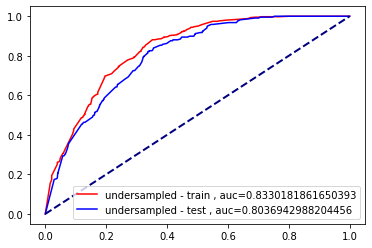

In [ ]:
y_score_train = xgb_model_under.predict_proba(X_undersampled)
fpr_train, tpr_train, _ = roc_curve(y_undersampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_undersampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='undersampled - train , auc='+str(auc_train))

y_score_test = xgb_model_under.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='undersampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

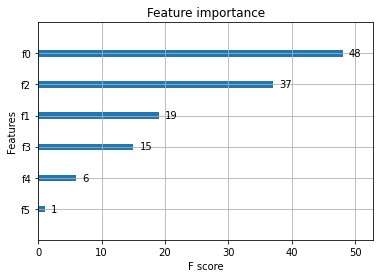

In [ ]:
xgb.plot_importance(xgb_model_under)

In [ ]:
print('XGBoost model - oversampled')
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_over = xgb_model.fit(X_oversampled, y_oversampled, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_over.predict(X_oversampled)
predicted_y.extend(predictions)
expected_y.extend(y_oversampled)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_over.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - oversampled
[0]	validation_0-auc:0.788718
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.790628
[2]	validation_0-auc:0.793647
[3]	validation_0-auc:0.800103
[4]	validation_0-auc:0.798642
[5]	validation_0-auc:0.797152
[6]	validation_0-auc:0.79973
[7]	validation_0-auc:0.797952
[8]	validation_0-auc:0.798454
Stopping. Best iteration:
[3]	validation_0-auc:0.800103

training set
              precision    recall  f1-score   support

           0       0.80      0.66      0.72      4389
           1       0.71      0.83      0.77      4389

    accuracy                           0.75      8778
   macro avg       0.76      0.75      0.75      8778
weighted avg       0.76      0.75      0.75      8778

test set
              precision    recall  f1-score   support

           0       0.97      0.66      0.79      1848
           1       0.22      0.81      0.35       218

    accuracy                           0.68      2066
   macro avg    

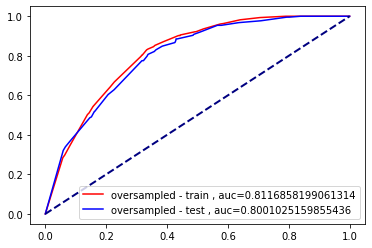

In [ ]:
y_score_train = xgb_model_over.predict_proba(X_oversampled)
fpr_train, tpr_train, _ = roc_curve(y_oversampled,  y_score_train[:,1])
auc_train = roc_auc_score(y_oversampled, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='oversampled - train , auc='+str(auc_train))

y_score_test = xgb_model_over.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='oversampled - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

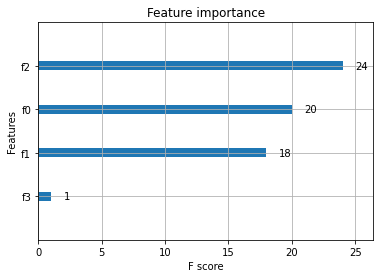

In [ ]:
xgb.plot_importance(xgb_model_over)

In [ ]:
print('XGBoost model - SMOTE')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE
[0]	validation_0-auc:0.772491
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.774243
[2]	validation_0-auc:0.786226
[3]	validation_0-auc:0.789902
[4]	validation_0-auc:0.788555
[5]	validation_0-auc:0.791586
[6]	validation_0-auc:0.793867
[7]	validation_0-auc:0.793918
[8]	validation_0-auc:0.795343
[9]	validation_0-auc:0.800342
[10]	validation_0-auc:0.800734
[11]	validation_0-auc:0.79988
[12]	validation_0-auc:0.800791
[13]	validation_0-auc:0.800006
[14]	validation_0-auc:0.800438
[15]	validation_0-auc:0.800398
[16]	validation_0-auc:0.797949
[17]	validation_0-auc:0.802076
[18]	validation_0-auc:0.801885
[19]	validation_0-auc:0.798675
[20]	validation_0-auc:0.799786
[21]	validation_0-auc:0.801479
[22]	validation_0-auc:0.801179
Stopping. Best iteration:
[17]	validation_0-auc:0.802076

training set
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      4389
           1       0.76      0.87

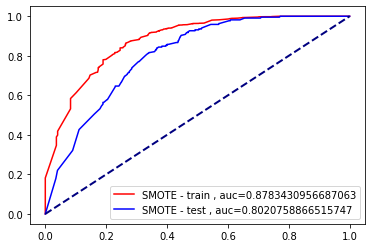

In [ ]:
y_score_train = xgb_model_SMOTE.predict_proba(X_SMOTE)
fpr_train, tpr_train, _ = roc_curve(y_SMOTE,  y_score_train[:,1])
auc_train = roc_auc_score(y_SMOTE, y_score_train[:,1])
plt.plot(fpr_train,tpr_train, color='red', label='SMOTE - train , auc='+str(auc_train))

y_score_test = xgb_model_SMOTE.predict_proba(X_test.to_numpy())
fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
auc_test = roc_auc_score(y_test, y_score_test[:,1])
plt.plot(fpr_test,tpr_test, color='Blue', label='SMOTE - test , auc='+str(auc_test))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend(loc=4)
plt.show()

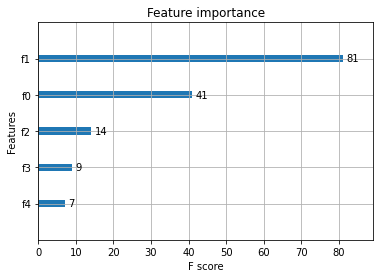

In [ ]:
xgb.plot_importance(xgb_model_SMOTE)

In [ ]:
print('XGBoost model - SMOTE - parameter tuning')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc",
 base_score=0.5,
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=3,
 min_child_weight=2,
 gamma=0.1,
 subsample=0.4,
 colsample_bytree=0.4,
 nthread=4)
predicted_y = []
expected_y = []

xgb_model_SMOTE_tuned = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=5, eval_set=[(X_test.to_numpy(), y_test)])
predictions =  xgb_model_SMOTE_tuned.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE_tuned.predict(X_test.to_numpy())
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

XGBoost model - SMOTE - parameter tuning
[0]	validation_0-auc:0.762471
Will train until validation_0-auc hasn't improved in 5 rounds.
[1]	validation_0-auc:0.797214
[2]	validation_0-auc:0.790975
[3]	validation_0-auc:0.783159
[4]	validation_0-auc:0.779795
[5]	validation_0-auc:0.785405
[6]	validation_0-auc:0.787428
Stopping. Best iteration:
[1]	validation_0-auc:0.797214

training set
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      4389
           1       0.74      0.78      0.76      4389

    accuracy                           0.76      8778
   macro avg       0.76      0.76      0.76      8778
weighted avg       0.76      0.76      0.76      8778

test set
              precision    recall  f1-score   support

           0       0.96      0.72      0.82      1848
           1       0.23      0.72      0.35       218

    accuracy                           0.72      2066
   macro avg       0.59      0.72      0.59      2066
weighted

## **Hyper parameter**

In [ ]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [ ]:
## hyper parameter tuning - grid search

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  {
    'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5, random_state=42)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_clv_GS = grid.fit(X_train_clv, y_train_clv)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.7min finished


In [ ]:
predicted_y = []
expected_y = []
predictions = xgb_model_clv_GS.predict(X_test_clv)
print('Best AUC Score: {}'.format(xgb_model_clv_GS.best_score_))
print(confusion_matrix(y_test_clv,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test_clv)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7691837009811533
[[1267  581]
 [  51  167]]
test set
              precision    recall  f1-score   support

           0       0.96      0.69      0.80      1848
           1       0.22      0.77      0.35       218

    accuracy                           0.69      2066
   macro avg       0.59      0.73      0.57      2066
weighted avg       0.88      0.69      0.75      2066



In [ ]:
print(xgb_model_clv_GS.best_params_)

{'clf__colsample_bytree': 0.4, 'clf__gamma': 0.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 2, 'clf__n_estimators': 300, 'fs__k': 2, 'fs__score_func': <function chi2 at 0x7f4667b3c290>}
